# Sprint
## 機械学習スクラッチ ロジスティック回帰
スクラッチでロジスティック回帰を実装した後、学習と検証を行なっていきます。

ロジスティック回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

以下に雛形を用意してあります。このScratchLogisticRegressionクラスにコードを書き加えていってください。推定関係のメソッドは線形回帰と異なり、ラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成します。

In [1]:
import numpy as np
import time
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    C : int
      正則化パラメータの逆数
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, C, no_bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.C = C
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ロジスティック回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)
        ## check val_bias
        if X_val is not None:
            X_val_biased = self._check_bias(X_val)
        ## reshape y
        y_reshaped = y.reshape(-1, 1)
        ## reshape y_val
        if y_val is not None:
            y_val_reshaped = y_val.reshape(-1, 1)


        ## initial theta = [[0], [0], ..., [0]]
        self.coef_ = np.random.randn(X_biased.shape[1], 1)

        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print('start learning with process')
        
        start_time = time.time()

        # loop learning
        for i in range(self.iter):
            ## calc hypothesis
            hypothesis = self._logistic_hypothesis(X_biased)

            ## add loss
            self.loss[i] = self._get_loss(hypothesis, y_reshaped)

            ## calc error
            error = self._get_error(hypothesis, y_reshaped)

            ## gradient descent
            self.coef_ = self._gradient_descent(X_biased, error)

            ## validation
            if (X_val is not None) and (y_val is not None):
                ## calc val_hypothesis
                hypothesis_val = self._logistic_hypothesis(X_val_biased)

                ### add val_loss
                self.val_loss[i] = self._get_loss(hypothesis_val, y_val_reshaped)
            
            ## output process
            if self.verbose:
                print(f'{i+1} loss : train: {self.loss[i]}, valid: {self.val_loss[i]}')
        
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f'Done! elapsed time: {elapsed_time:.5f}s')

    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba =  self._logistic_hypothesis(X_biased)
        # round to predict y
        pred = (lambda x:(x*2+1)//2)(pred_proba).astype(np.int32)

        return pred

    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba = self._logistic_hypothesis(X_biased)

        return pred_proba

    def _logistic_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰の仮定関数による推定結果

        """
        linear_h = np.matmul(X, self.coef_)

        h = self._sigmoid(linear_h)

        return h

    def _sigmoid(self, X):
        """
        シグモイド関数の計算結果を返す

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, 1)
            線形回帰における仮定関数の計算結果

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            シグモイド関数の計算結果
        """
        exp_term = np.exp(-X)

        s = 1 / (1+exp_term)

        return s

    def _gradient_descent(self, X, error):
        """
        パラメータベクトルの値を更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        error : 次の形のndarray, shape (n_samples, 1)
            予測値と正解値の差

        Returns
        -------
        new_coef_ : 次の形のndarray, shape (n_samples, 1)
            更新された新たなパラメータベクトル
        """
        # m : number of samples
        m = X.shape[0]

        # calc
        ## Regularization term
        reg_term = self.coef_[1:] / (self.C*m)
        if not self.no_bias:
            reg_term_biased = np.concatenate((np.zeros((1, 1)), reg_term), axis=0)
        else:
            reg_term_biased = reg_term
        ## new param
        new_coef_ = self.coef_ - (((self.lr * np.matmul(X.T, error)) / m) + reg_term_biased) 
        
        return new_coef_

    def _get_error(self, hypothesis, y):
        """
        誤差ベクトルを求める

        Parameters
        ----------
        hypothesis : 次の形のndarray, shape (n_samples, 1)
            予測値ベクトル
        y : 次の形のndarray, shape (n_samples, 1)
            パラメータベクトル

        Returns
        -------
        error: 次の形のndarray, shape (n_samples, 1)
            誤差ベクトル
        """
        error = hypothesis - y

        return error

    def _check_bias(self, v):
        """
        no_biasフラグに従い、ベクトルにバイアス項をよしなにする

        Parameters
        ----------
        v : 次の形のndarray, shape (*, n_features)
            ベクトル

        Returns
        ----------
        v_biased : 次の形のndarray, shape (*, n_features+1)
            バイアス項を追加したりしなかったりしたベクトル
        """
        m = v.shape[0]

        if not self.no_bias:
            v_biased = np.concatenate((np.ones((m, 1)), v), axis=1)
        else:
            v_biased = v

        return v_biased

    def _get_loss(self, y_pred, y):
        """
        目的関数（損失関数）の計算

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
            推定した値
        y : 次の形のndarray, shape (n_samples,)
            正解値

        Returns
        ----------
        loss : numpy.float
            目的関数（損失関数）
        """
        # m : number of samples
        m = y.shape[0]

        # calc
        ## y_true = 1
        log_positive_sum = np.sum(y * np.log(y_pred))
        ## y_true = 0
        log_negative_sum = np.sum((1-y) * np.log(1-y_pred))
        ## Regularization term (except theta_0)
        reg_term_sum = np.sum(self.coef_[1:]**2)

        loss = ((-log_positive_sum-log_positive_sum) / m) + (reg_term_sum / (2*m*self.C))

        return loss

# 【問題1】
## 仮定関数
ロジスティック回帰の仮定関数のメソッドをScratchLogisticRegressionクラスに実装してください。

ロジスティック回帰の仮定関数は、線形回帰の仮定関数を **シグモイド関数** に通したものです。シグモイド関数は以下の式で表されます。

$$
g(z) = \frac{1}{1+e^{−z}}
$$

線形回帰の仮定関数は次の式でした。

$$
h_\theta(x) = \theta^T \cdot x
$$

まとめて書くと、ロジスティック回帰の仮定関数は次のようになります。

$$
h_\theta(x) = \frac{1}{1+e^{−\theta^T \cdot x}}
$$

$x$: 特徴量ベクトル

$θ$: パラメータ（重み）ベクトル

```python
    def _logistic_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰の仮定関数による推定結果

        """
        linear_h = np.matmul(X, self.coef_)

        h = self._sigmoid(linear_h)

        return h

    def _sigmoid(self, X):
        """
        シグモイド関数の計算結果を返す

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, 1)
            線形回帰における仮定関数の計算結果

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            シグモイド関数の計算結果
        """
        exp_term = np.exp(-X)

        s = 1 / (1+exp_term)

        return s
```

# 【問題2】
## 最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$$
\theta_j := \theta_j - \alpha \frac{\partial J(\theta)}{\partial \theta_j}\\
\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\
\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1
$$

$α$: 学習率

$i$: サンプルのインデックス

$j$: 特徴量のインデックス

$m$: 入力されるデータの数

$h_θ()$: 仮定関数

$x$: 特徴量ベクトル

$θ$: パラメータ（重み）ベクトル

$x(i)$: i番目のサンプルの特徴量ベクトル

$y(i)$: i番目のサンプルの正解ラベル

$θ_j$: j番目のパラメータ（重み）

$λ$: 正則化パラメータ

```python
    def _gradient_descent(self, X, error):
        """
        パラメータベクトルの値を更新する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
        error : 次の形のndarray, shape (n_samples, 1)
            予測値と正解値の差

        Returns
        -------
        new_coef_ : 次の形のndarray, shape (n_samples, 1)
            更新された新たなパラメータベクトル
        """
        # m : number of samples
        m = X.shape[0]

        # calc
        ## Regularization term
        reg_term = np.concatenate((np.zeros((1, 1)), ((self.coef_[1:]) / (self.C*m))), axis=0)
        ## new param
        new_coef_ = self.coef_ - (((self.lr * np.matmul(X.T, error)) / m) + reg_term) 
        
        return new_coef_    
```

# 【問題3】
## 推定
推定する仕組みを実装してください。ScratchLogisticRegressionクラスの雛形に含まれるpredictメソッドとpredict_probaメソッドに書き加えてください。

仮定関数$h_θ(x)$の出力がpredict_probaの返り値、さらにその値に閾値を設けて1と0のラベルとしたものがpredictの返り値となります。

```python
    def predict(self, X):
        """
        ロジスティック回帰を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba =  self._logistic_hypothesis(X_biased)
        # round to predict y
        pred = (lambda x:(x*2+1)//2)(pred_proba).astype(np.int32)

        return pred
    
    def predict_proba(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        # preparing
        ## check bias 
        X_biased = self._check_bias(X)

        # predict probability of y
        pred_proba = self._logistic_hypothesis(X_biased)

        return pred_proba
```

# 【問題4】
## 目的関数
以下の数式で表されるロジスティック回帰の **目的関数（損失関数）** を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

なお、この数式には正則化項が含まれています。

$$
J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] +
\frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\
$$

$m$: 入力されるデータの数

$h_θ()$: 仮定関数

$x$: 特徴量ベクトル

$θ$: パラメータ（重み）ベクトル

$x(i)$: i番目のサンプルの特徴量ベクトル

$y(i)$: i番目のサンプルの正解ラベル

$θ_j$: j番目のパラメータ（重み）

$n$: 特徴量の数

$λ$: 正則化パラメータ

```python
    def _get_loss(self, y_pred, y):
        """
        目的関数（損失関数）の計算

        Parameters
        ----------
        y_pred : 次の形のndarray, shape (n_samples,)
            推定した値
        y : 次の形のndarray, shape (n_samples,)
            正解値

        Returns
        ----------
        loss : numpy.float
            目的関数（損失関数）
        """
        # m : number of samples
        m = y.shape[0]

        # calc
        ## y_true = 1
        log_positive_sum = np.sum(y * np.log(y_pred))
        ## y_true = 0
        log_negative_sum = np.sum((1-y) * np.log(1-y_pred))
        ## Regularization term (except theta_0)
        reg_term_sum = np.sum(self.coef_[1:]**2)

        loss = ((-log_positive_sum-log_positive_sum) / m) + ((self.C*reg_term_sum) / (2*m))

        return loss
```

# 【問題5】
## 学習と推定
機械学習スクラッチ入門のSprintで用意したirisデータセットのvirgicolorとvirginicaの2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

特徴量についてはまず'sepal_length', 'petal_length'を用いて分類する。

In [2]:
import pandas as pd
from sklearn.datasets import load_iris
data = load_iris()

# 説明変数
X = pd.DataFrame(data=data.get('data'), 
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

# 目的変数
Y = pd.DataFrame(data=data.get('target'),
    columns=['Species'])

# 列の抽出
df_iris = pd.concat((X, Y), axis=1)[['sepal_length', 'petal_length', 'Species']]
# Species: virgicolor = 1, verginica = 2
df_iris = df_iris[df_iris['Species'] != 0]

display(df_iris)

,sepal_length,petal_length,Species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1
...,...,...,...
145,6.7,5.2,2
146,6.3,5.0,2
147,6.5,5.2,2
148,6.2,5.4,2


In [3]:
from sklearn.model_selection import train_test_split

# get numpy array
X_values = df_iris[['sepal_length', 'petal_length']].values
# get numpy array and replace Species: virgicolor = 0, verginica = 1
y_values = df_iris['Species'].values-1

X_train, X_val, y_train, y_val = train_test_split(X_values, y_values)

In [4]:
# Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

print(X_train_std)
print(X_val_std)

[[ 0.58358928  0.25057254]
 [-1.16717856 -1.2155434 ]
 [-2.28130355 -0.68241033]
 [ 2.1751964   1.45012195]
 [-1.16717856 -1.08226013]
 [-0.21221428  0.51713908]
 [-0.84885713  0.11728928]
 [-0.84885713  0.11728928]
 [ 0.10610714  0.38385581]
 [-0.84885713  0.11728928]
 [-0.68969642 -0.28256053]
 [-0.53053571  0.11728928]
 [-0.05305357 -0.01599399]
 [-0.53053571 -0.01599399]
 [-2.28130355 -2.28180954]
 [-1.48549998 -0.68241033]
 [-1.16717856 -1.48210994]
 [-1.00801785 -1.08226013]
 [-0.21221428 -0.28256053]
 [ 0.10610714  0.78370561]
 [-0.53053571 -0.68241033]
 [-1.32633927 -1.34882667]
 [-1.16717856 -0.68241033]
 [ 1.37939284  1.05027215]
 [ 0.9019107   0.51713908]
 [ 0.9019107  -0.14927726]
 [ 1.53855355  1.71668849]
 [-0.68969642 -1.08226013]
 [-0.53053571 -0.28256053]
 [ 0.58358928  0.91698888]
 [ 0.9019107   0.11728928]
 [ 0.10610714 -0.68241033]
 [-0.84885713 -1.2155434 ]
 [ 0.58358928  1.05027215]
 [-0.05305357 -0.14927726]
 [-0.21221428 -0.68241033]
 [-0.05305357 -0.8156936 ]
 

In [5]:
# learn and predict
clf = ScratchLogisticRegression(num_iter=10000, lr=0.01, C=10, no_bias=False, verbose=True)
clf.fit(X_train_std, y_train, X_val_std, y_val)
print(clf.coef_)

start learning with process
1 loss : train: 0.920722877641689, valid: 0.6151791644667511
2 loss : train: 0.9178473163227774, valid: 0.6129607325306915
3 loss : train: 0.9149981140048233, valid: 0.6107620348934913
4 loss : train: 0.9121750248623276, valid: 0.6085828839116596
5 loss : train: 0.9093778035046437, valid: 0.6064230926190187
6 loss : train: 0.906606205043496, valid: 0.6042824747695487
7 loss : train: 0.9038599851587524, valid: 0.602160844878732
8 loss : train: 0.9011389001624351, valid: 0.6000580182634021
9 loss : train: 0.8984427070609512, valid: 0.5979738110801094
10 loss : train: 0.8957711636155304, valid: 0.5959080403620096
11 loss : train: 0.893124028400864, valid: 0.5938605240542928
12 loss : train: 0.890501060861933, valid: 0.5918310810481621
13 loss : train: 0.8879020213690253, valid: 0.589819531213381
14 loss : train: 0.8853266712709407, valid: 0.5878256954294028
15 loss : train: 0.882774772946379, valid: 0.5858493956151031
16 loss : train: 0.8802460898535261, valid:

961 loss : train: 0.443698874922817, valid: 0.252730454429891
962 loss : train: 0.4436087414636579, valid: 0.25267415238575147
963 loss : train: 0.4435187873921837, valid: 0.2526179713373556
964 loss : train: 0.4434290123060491, valid: 0.25256191097826997
965 loss : train: 0.4433394158040134, valid: 0.25250597100303207
966 loss : train: 0.4432499974859361, valid: 0.2524501511071457
967 loss : train: 0.44316075695277324, valid: 0.2523944509870773
968 loss : train: 0.44307169380657296, valid: 0.2523388703402524
969 loss : train: 0.44298280765047243, valid: 0.2522834088650513
970 loss : train: 0.44289409808869273, valid: 0.2522280662608053
971 loss : train: 0.44280556472653565, valid: 0.2521728422277931
972 loss : train: 0.44271720717038004, valid: 0.25211773646723706
973 loss : train: 0.44262902502767704, valid: 0.25206274868129885
974 loss : train: 0.4425410179069467, valid: 0.2520078785730764
975 loss : train: 0.4424531854177746, valid: 0.2519531258465994
976 loss : train: 0.4423655271

1747 loss : train: 0.40703499802630877, valid: 0.23054060790003866
1748 loss : train: 0.4070143590513923, valid: 0.2305284971298432
1749 loss : train: 0.4069937573312555, valid: 0.23051640861204678
1750 loss : train: 0.40697319279659483, valid: 0.2305043423037707
1751 loss : train: 0.40695266537824315, valid: 0.23049229816222597
1752 loss : train: 0.4069321750071693, valid: 0.2304802761447133
1753 loss : train: 0.4069117216144774, valid: 0.23046827620862265
1754 loss : train: 0.40689130513140714, valid: 0.23045629831143308
1755 loss : train: 0.4068709254893332, valid: 0.23044434241071293
1756 loss : train: 0.4068505826197645, valid: 0.23043240846411897
1757 loss : train: 0.40683027645434483, valid: 0.23042049642939674
1758 loss : train: 0.40681000692485203, valid: 0.23040860626437992
1759 loss : train: 0.4067897739631977, valid: 0.23039673792699036
1760 loss : train: 0.4067695775014267, valid: 0.23038489137523796
1761 loss : train: 0.40674941747171767, valid: 0.23037306656722015
1762 l

2577 loss : train: 0.39810378099258953, valid: 0.2253348906287299
2578 loss : train: 0.3980990694406197, valid: 0.22533216172218887
2579 loss : train: 0.3980943661872879, valid: 0.22532943763830604
2580 loss : train: 0.3980896712178672, valid: 0.22532671836846055
2581 loss : train: 0.3980849845176573, valid: 0.22532400390404728
2582 loss : train: 0.39808030607198425, valid: 0.2253212942364769
2583 loss : train: 0.39807563586620054, valid: 0.22531858935717577
2584 loss : train: 0.39807097388568513, valid: 0.22531588925758578
2585 loss : train: 0.3980663201158433, valid: 0.22531319392916477
2586 loss : train: 0.39806167454210656, valid: 0.22531050336338582
2587 loss : train: 0.3980570371499325, valid: 0.22530781755173784
2588 loss : train: 0.39805240792480534, valid: 0.2253051364857252
2589 loss : train: 0.3980477868522348, valid: 0.22530246015686783
2590 loss : train: 0.3980431739177572, valid: 0.2252997885567011
2591 loss : train: 0.39803856910693447, valid: 0.22529712167677604
2592 lo

3507 loss : train: 0.39594467292996216, valid: 0.22408589790702502
3508 loss : train: 0.39594375276598703, valid: 0.22408536617269473
3509 loss : train: 0.39594283421296833, valid: 0.22408483536958387
3510 loss : train: 0.3959419172680819, valid: 0.22408430549605823
3511 loss : train: 0.3959410019285085, valid: 0.22408377655048667
3512 loss : train: 0.39594008819143367, valid: 0.22408324853124065
3513 loss : train: 0.3959391760540481, valid: 0.22408272143669475
3514 loss : train: 0.3959382655135473, valid: 0.22408219526522635
3515 loss : train: 0.39593735656713197, valid: 0.22408167001521562
3516 loss : train: 0.39593644921200727, valid: 0.22408114568504559
3517 loss : train: 0.39593554344538373, valid: 0.22408062227310221
3518 loss : train: 0.3959346392644764, valid: 0.22408009977777427
3519 loss : train: 0.3959337366665056, valid: 0.22407957819745328
3520 loss : train: 0.39593283564869614, valid: 0.22407905753053373
3521 loss : train: 0.39593193620827805, valid: 0.22407853777541287
3

4404 loss : train: 0.3955281305822875, valid: 0.22384520769634378
4405 loss : train: 0.3955279392966047, valid: 0.22384509716167109
4406 loss : train: 0.3955277483454926, valid: 0.2238449868203027
4407 loss : train: 0.39552755772836595, valid: 0.2238448766719006
4408 loss : train: 0.3955273674446405, valid: 0.2238447667161271
4409 loss : train: 0.3955271774937331, valid: 0.22384465695264538
4410 loss : train: 0.3955269878750616, valid: 0.22384454738111903
4411 loss : train: 0.39552679858804457, valid: 0.2238444380012122
4412 loss : train: 0.39552660963210207, valid: 0.22384432881258984
4413 loss : train: 0.395526421006655, valid: 0.2238442198149173
4414 loss : train: 0.395526232711125, valid: 0.22384411100786059
4415 loss : train: 0.3955260447449351, valid: 0.22384400239108623
4416 loss : train: 0.39552585710750915, valid: 0.22384389396426146
4417 loss : train: 0.3955256697982721, valid: 0.22384378572705388
4418 loss : train: 0.3955254828166498, valid: 0.223843677679132
4419 loss : tra

5314 loss : train: 0.3954409994200325, valid: 0.2237948537019199
5315 loss : train: 0.3954409605297758, valid: 0.22379483122251487
5316 loss : train: 0.39544092170754364, valid: 0.2237948087824216
5317 loss : train: 0.395440882953217, valid: 0.2237947863815712
5318 loss : train: 0.3954408442666773, valid: 0.22379476401989512
5319 loss : train: 0.39544080564780576, valid: 0.22379474169732494
5320 loss : train: 0.39544076709648424, valid: 0.22379471941379217
5321 loss : train: 0.3954407286125944, valid: 0.22379469716922865
5322 loss : train: 0.3954406901960186, valid: 0.22379467496356614
5323 loss : train: 0.3954406518466388, valid: 0.2237946527967367
5324 loss : train: 0.3954406135643377, valid: 0.2237946306686724
5325 loss : train: 0.39544057534899785, valid: 0.22379460857930542
5326 loss : train: 0.3954405372005022, valid: 0.2237945865285681
5327 loss : train: 0.3954404991187338, valid: 0.22379456451639293
5328 loss : train: 0.39544046110357606, valid: 0.22379454254271255
5329 loss : 

6239 loss : train: 0.3954231690178475, valid: 0.22378454609558526
6240 loss : train: 0.3954231613181455, valid: 0.2237845416435446
6241 loss : train: 0.3954231536319145, valid: 0.22378453719929173
6242 loss : train: 0.39542314595913125, valid: 0.22378453276281285
6243 loss : train: 0.395423138299772, valid: 0.22378452833409426
6244 loss : train: 0.39542313065381335, valid: 0.2237845239131226
6245 loss : train: 0.3954231230212319, valid: 0.22378451949988423
6246 loss : train: 0.39542311540200414, valid: 0.22378451509436562
6247 loss : train: 0.39542310779610684, valid: 0.2237845106965533
6248 loss : train: 0.39542310020351656, valid: 0.22378450630643376
6249 loss : train: 0.3954230926242101, valid: 0.22378450192399352
6250 loss : train: 0.39542308505816415, valid: 0.22378449754921928
6251 loss : train: 0.3954230775053556, valid: 0.22378449318209745
6252 loss : train: 0.39542306996576126, valid: 0.22378448882261479
6253 loss : train: 0.39542306243935793, valid: 0.22378448447075786
6254 l

7187 loss : train: 0.3954196050208046, valid: 0.22378248511933135
7188 loss : train: 0.39541960355718736, valid: 0.22378248427279118
7189 loss : train: 0.39541960209613153, valid: 0.22378248342773222
7190 loss : train: 0.39541960063763254, valid: 0.22378248258415193
7191 loss : train: 0.3954195991816861, valid: 0.2237824817420477
7192 loss : train: 0.3954195977282876, valid: 0.22378248090141695
7193 loss : train: 0.3954195962774327, valid: 0.22378248006225698
7194 loss : train: 0.39541959482911676, valid: 0.22378247922456548
7195 loss : train: 0.3954195933833355, valid: 0.2237824783883396
7196 loss : train: 0.3954195919400844, valid: 0.22378247755357694
7197 loss : train: 0.39541959049935904, valid: 0.22378247672027482
7198 loss : train: 0.39541958906115504, valid: 0.22378247588843084
7199 loss : train: 0.39541958762546797, valid: 0.22378247505804233
7200 loss : train: 0.3954195861922934, valid: 0.2237824742291068
7201 loss : train: 0.395419584761627, valid: 0.22378247340162163
7202 lo

7327 loss : train: 0.39541942314548256, valid: 0.22378237992245878
7328 loss : train: 0.3954194220001611, valid: 0.2237823792599886
7329 loss : train: 0.3954194208568441, valid: 0.22378237859867767
7330 loss : train: 0.3954194197155281, valid: 0.22378237793852382
7331 loss : train: 0.3954194185762095, valid: 0.2237823772795252
7332 loss : train: 0.39541941743888487, valid: 0.22378237662167969
7333 loss : train: 0.3954194163035506, valid: 0.2237823759649853
7334 loss : train: 0.3954194151702033, valid: 0.22378237530943998
7335 loss : train: 0.39541941403883957, valid: 0.22378237465504164
7336 loss : train: 0.3954194129094557, valid: 0.22378237400178846
7337 loss : train: 0.39541941178204865, valid: 0.2237823733496784
7338 loss : train: 0.39541941065661446, valid: 0.22378237269870935
7339 loss : train: 0.3954194095331499, valid: 0.22378237204887935
7340 loss : train: 0.39541940841165174, valid: 0.22378237140018645
7341 loss : train: 0.3954194072921162, valid: 0.22378237075262866
7342 los

8141 loss : train: 0.3954189259989566, valid: 0.22378209233874832
8142 loss : train: 0.3954189257237716, valid: 0.22378209217953898
8143 loss : train: 0.39541892544906826, valid: 0.22378209202060834
8144 loss : train: 0.39541892517484584, valid: 0.22378209186195583
8145 loss : train: 0.39541892490110336, valid: 0.22378209170358102
8146 loss : train: 0.39541892462784023, valid: 0.2237820915454834
8147 loss : train: 0.3954189243550553, valid: 0.22378209138766247
8148 loss : train: 0.395418924082748, valid: 0.22378209123011777
8149 loss : train: 0.3954189238109173, valid: 0.22378209107284885
8150 loss : train: 0.39541892353956243, valid: 0.2237820909158551
8151 loss : train: 0.39541892326868255, valid: 0.22378209075913622
8152 loss : train: 0.3954189229982769, valid: 0.22378209060269158
8153 loss : train: 0.39541892272834456, valid: 0.2237820904465208
8154 loss : train: 0.3954189224588848, valid: 0.22378209029062326
8155 loss : train: 0.39541892218989666, valid: 0.22378209013499864
8156 l

9027 loss : train: 0.3954188020891201, valid: 0.2237820206436565
9028 loss : train: 0.3954188020308568, valid: 0.22378202060993982
9029 loss : train: 0.39541880197269536, valid: 0.2237820205762822
9030 loss : train: 0.39541880191463574, valid: 0.22378202054268348
9031 loss : train: 0.39541880185667794, valid: 0.22378202050914364
9032 loss : train: 0.3954188017988215, valid: 0.22378202047566248
9033 loss : train: 0.39541880174106636, valid: 0.22378202044224
9034 loss : train: 0.39541880168341237, valid: 0.22378202040887601
9035 loss : train: 0.3954188016258593, valid: 0.22378202037557038
9036 loss : train: 0.39541880156840703, valid: 0.22378202034232303
9037 loss : train: 0.3954188015110553, valid: 0.22378202030913397
9038 loss : train: 0.3954188014538041, valid: 0.22378202027600294
9039 loss : train: 0.395418801396653, valid: 0.22378202024292987
9040 loss : train: 0.39541880133960194, valid: 0.22378202020991472
9041 loss : train: 0.3954188012826509, valid: 0.22378202017695747
9042 loss

9995 loss : train: 0.3954187749149226, valid: 0.2237820049167308
9996 loss : train: 0.3954187749042418, valid: 0.22378200491054837
9997 loss : train: 0.3954187748935796, valid: 0.2237820049043768
9998 loss : train: 0.39541877488293614, valid: 0.22378200489821606
9999 loss : train: 0.39541877487231136, valid: 0.223782004892066
10000 loss : train: 0.3954187748617052, valid: 0.22378200488592684
Done! elapsed time: 2.04285s
[[0.2809771 ]
 [0.1525339 ]
 [1.11256072]]


In [6]:
# learn and predict with no bias
clf_no_bias = ScratchLogisticRegression(num_iter=10000, lr=0.01, C=10, no_bias=True, verbose=True)
clf_no_bias.fit(X_train_std, y_train, X_val_std, y_val)
print(clf_no_bias.coef_)

start learning with process
1 loss : train: 0.7583296861300527, valid: 0.49040136780442434
2 loss : train: 0.7569542905814203, valid: 0.4892540221014886
3 loss : train: 0.7555933783139518, valid: 0.4881176996978163
4 loss : train: 0.7542467518687122, valid: 0.48699225995103634
5 loss : train: 0.7529142164408044, valid: 0.4858775641158968
6 loss : train: 0.7515955798572649, valid: 0.4847734753254474
7 loss : train: 0.7502906525544265, valid: 0.48367985857200047
8 loss : train: 0.7489992475547833, valid: 0.48259658068789496
9 loss : train: 0.7477211804433995, valid: 0.48152351032608476
10 loss : train: 0.7464562693439034, valid: 0.4804605179405759
11 loss : train: 0.7452043348940933, valid: 0.47940747576673426
12 loss : train: 0.7439652002212045, valid: 0.4783642578014816
13 loss : train: 0.7427386909168563, valid: 0.47733073978340224
14 loss : train: 0.7415246350117227, valid: 0.4763067991727779
15 loss : train: 0.740322862949953, valid: 0.4752923151315689
16 loss : train: 0.73913320756

922 loss : train: 0.5154901126800804, valid: 0.3009665590508974
923 loss : train: 0.5154158581314908, valid: 0.30093571975563677
924 loss : train: 0.5153417395728291, valid: 0.3009049708180391
925 loss : train: 0.5152677568342844, valid: 0.3008743120499413
926 loss : train: 0.5151939097461591, valid: 0.3008437432636663
927 loss : train: 0.5151201981388689, valid: 0.300813264272021
928 loss : train: 0.5150466218429423, valid: 0.3007828748882946
929 loss : train: 0.5149731806890191, valid: 0.300752574926256
930 loss : train: 0.5148998745078511, valid: 0.3007223642001526
931 loss : train: 0.5148267031303017, valid: 0.3006922425247077
932 loss : train: 0.5147536663873434, valid: 0.30066220971511926
933 loss : train: 0.51468076411006, valid: 0.3006322655870572
934 loss : train: 0.5146079961296443, valid: 0.30060240995666193
935 loss : train: 0.5145353622773979, valid: 0.3005726426405426
936 loss : train: 0.5144628623847317, valid: 0.300542963455775
937 loss : train: 0.5143904962831644, vali

1873 loss : train: 0.4860832829592732, valid: 0.295572777328028
1874 loss : train: 0.4860793775671264, valid: 0.29558133353208715
1875 loss : train: 0.48607550474356226, valid: 0.29558990592622886
1876 loss : train: 0.48607166443990546, valid: 0.2955984944860742
1877 loss : train: 0.4860678566075639, valid: 0.2956070991872894
1878 loss : train: 0.4860640811980284, valid: 0.29561572000558567
1879 loss : train: 0.48606033816287264, valid: 0.29562435691671973
1880 loss : train: 0.4860566274537531, valid: 0.29563300989649244
1881 loss : train: 0.4860529490224082, valid: 0.29564167892075016
1882 loss : train: 0.4860493028206594, valid: 0.29565036396538347
1883 loss : train: 0.48604568880040994, valid: 0.2956590650063277
1884 loss : train: 0.48604210691364497, valid: 0.29566778201956256
1885 loss : train: 0.48603855711243155, valid: 0.2956765149811121
1886 loss : train: 0.48603503934891856, valid: 0.29568526386704436
1887 loss : train: 0.4860315535753365, valid: 0.29569402865347183
1888 loss

2808 loss : train: 0.4919328387572163, valid: 0.30828836589678216
2809 loss : train: 0.4919456572231587, valid: 0.30830518338683083
2810 loss : train: 0.49195848416938814, valid: 0.30832200484146105
2811 loss : train: 0.49197131958325313, valid: 0.30833883025369224
2812 loss : train: 0.4919841634521178, valid: 0.30835565961655076
2813 loss : train: 0.49199701576336274, valid: 0.308372492923071
2814 loss : train: 0.4920098765043833, valid: 0.3083893301662944
2815 loss : train: 0.49202274566259113, valid: 0.3084061713392701
2816 loss : train: 0.4920356232254135, valid: 0.3084230164350547
2817 loss : train: 0.4920485091802936, valid: 0.3084398654467121
2818 loss : train: 0.49206140351468924, valid: 0.3084567183673136
2819 loss : train: 0.49207430621607506, valid: 0.3084735751899382
2820 loss : train: 0.49208721727194066, valid: 0.3084904359076718
2821 loss : train: 0.4921001366697914, valid: 0.3085073005136083
2822 loss : train: 0.4921130643971482, valid: 0.30852416900084867
2823 loss : t

2951 loss : train: 0.49384619622313897, valid: 0.3107303092908568
2952 loss : train: 0.49386010609692427, valid: 0.31074762627256597
2953 loss : train: 0.49387402279210324, valid: 0.31076494629268275
2954 loss : train: 0.49388794629807425, valid: 0.3107822693452157
2955 loss : train: 0.493901876604248, valid: 0.31079959542417934
2956 loss : train: 0.4939158137000485, valid: 0.3108169245235946
2957 loss : train: 0.49392975757491253, valid: 0.310834256637489
2958 loss : train: 0.4939437082182902, valid: 0.31085159175989624
2959 loss : train: 0.49395766561964394, valid: 0.31086892988485637
2960 loss : train: 0.4939716297684494, valid: 0.3108862710064158
2961 loss : train: 0.49398560065419495, valid: 0.3109036151186275
2962 loss : train: 0.49399957826638236, valid: 0.3109209622155506
2963 loss : train: 0.4940135625945255, valid: 0.31093831229125063
2964 loss : train: 0.4940275536281516, valid: 0.31095566533979924
2965 loss : train: 0.4940415513568003, valid: 0.3109730213552747
2966 loss : 

3852 loss : train: 0.5081424981117627, valid: 0.32698346367582803
3853 loss : train: 0.5081594668978174, valid: 0.3270017158190971
3854 loss : train: 0.5081764366753313, valid: 0.32701996755678914
3855 loss : train: 0.5081934074407056, valid: 0.32703821888669593
3856 loss : train: 0.5082103791903458, valid: 0.327056469806612
3857 loss : train: 0.5082273519206617, valid: 0.32707472031433454
3858 loss : train: 0.5082443256280677, valid: 0.32709297040766316
3859 loss : train: 0.5082613003089821, valid: 0.32711122008440024
3860 loss : train: 0.5082782759598276, valid: 0.32712946934235065
3861 loss : train: 0.5082952525770313, valid: 0.32714771817932187
3862 loss : train: 0.5083122301570244, valid: 0.3271659665931239
3863 loss : train: 0.5083292086962424, valid: 0.32718421458156915
3864 loss : train: 0.508346188191125, valid: 0.32720246214247306
3865 loss : train: 0.5083631686381164, valid: 0.3272207092736532
3866 loss : train: 0.5083801500336647, valid: 0.32723895597292985
3867 loss : trai

3986 loss : train: 0.5104237928109585, valid: 0.3294248034107085
3987 loss : train: 0.5104408640044676, valid: 0.3294429825126137
3988 loss : train: 0.510457935743553, valid: 0.3294611609351289
3989 loss : train: 0.510475008025148, valid: 0.3294793386763704
3990 loss : train: 0.5104920808461901, valid: 0.32949751573445707
3991 loss : train: 0.5105091542036209, valid: 0.32951569210750953
3992 loss : train: 0.5105262280943844, valid: 0.3295338677936511
3993 loss : train: 0.5105433025154295, valid: 0.329552042791007
3994 loss : train: 0.5105603774637083, valid: 0.32957021709770484
3995 loss : train: 0.5105774529361763, valid: 0.3295883907118746
3996 loss : train: 0.5105945289297933, valid: 0.3296065636316483
3997 loss : train: 0.5106116054415217, valid: 0.32962473585516033
3998 loss : train: 0.5106286824683287, valid: 0.32964290738054713
3999 loss : train: 0.5106457600071842, valid: 0.3296610782059478
4000 loss : train: 0.5106628380550624, valid: 0.3296792483295031
4001 loss : train: 0.51

4907 loss : train: 0.5260692442769374, valid: 0.3456918242772917
4908 loss : train: 0.526085891710463, valid: 0.34570881489742855
4909 loss : train: 0.5261025379912779, valid: 0.3457258038183636
4910 loss : train: 0.5261191831184047, valid: 0.34574279103955663
4911 loss : train: 0.5261358270908684, valid: 0.3457597765604684
4912 loss : train: 0.5261524699076944, valid: 0.3457767603805606
4913 loss : train: 0.5261691115679101, valid: 0.34579374249929584
4914 loss : train: 0.5261857520705437, valid: 0.3458107229161371
4915 loss : train: 0.526202391414625, valid: 0.345827701630549
4916 loss : train: 0.5262190295991849, valid: 0.34584467864199636
4917 loss : train: 0.5262356666232555, valid: 0.34586165394994517
4918 loss : train: 0.5262523024858703, valid: 0.3458786275538621
4919 loss : train: 0.5262689371860643, valid: 0.345895599453215
4920 loss : train: 0.5262855707228735, valid: 0.34591256964747236
4921 loss : train: 0.5263022030953352, valid: 0.34592953813610344
4922 loss : train: 0.5

5140 loss : train: 0.5299150551829893, valid: 0.34960368776244344
5141 loss : train: 0.5299314101627051, valid: 0.34962026957300385
5142 loss : train: 0.5299477637942789, valid: 0.3496368495801904
5143 loss : train: 0.5299641160770002, valid: 0.34965342778364245
5144 loss : train: 0.5299804670101588, valid: 0.3496700041829999
5145 loss : train: 0.529996816593046, valid: 0.3496865787779036
5146 loss : train: 0.5300131648249538, valid: 0.34970315156799486
5147 loss : train: 0.5300295117051752, valid: 0.3497197225529157
5148 loss : train: 0.5300458572330045, valid: 0.349736291732309
5149 loss : train: 0.5300622014077369, valid: 0.34975285910581816
5150 loss : train: 0.530078544228668, valid: 0.349769424673087
5151 loss : train: 0.5300948856950953, valid: 0.3497859884337608
5152 loss : train: 0.5301112258063168, valid: 0.3498025503874844
5153 loss : train: 0.5301275645616311, valid: 0.34981911053390435
5154 loss : train: 0.5301439019603391, valid: 0.34983566887266715
5155 loss : train: 0.5

5894 loss : train: 0.541824868918038, valid: 0.3615765555524208
5895 loss : train: 0.541840064372655, valid: 0.3615917152132592
5896 loss : train: 0.5418552581634711, valid: 0.36160687294867994
5897 loss : train: 0.5418704502902916, valid: 0.3616220287586729
5898 loss : train: 0.5418856407529217, valid: 0.36163718264322836
5899 loss : train: 0.5419008295511671, valid: 0.36165233460233737
5900 loss : train: 0.5419160166848344, valid: 0.36166748463599074
5901 loss : train: 0.54193120215373, valid: 0.3616826327441799
5902 loss : train: 0.5419463859576613, valid: 0.3616977789268963
5903 loss : train: 0.5419615680964358, valid: 0.36171292318413223
5904 loss : train: 0.5419767485698616, valid: 0.3617280655158795
5905 loss : train: 0.5419919273777469, valid: 0.3617432059221306
5906 loss : train: 0.5420071045199009, valid: 0.3617583444028787
5907 loss : train: 0.5420222799961327, valid: 0.36177348095811657
5908 loss : train: 0.5420374538062522, valid: 0.3617886155878377
5909 loss : train: 0.54

6146 loss : train: 0.5456010589610988, valid: 0.36533591724753867
6147 loss : train: 0.5456158300615463, valid: 0.36535059212676474
6148 loss : train: 0.5456305994618622, valid: 0.36536526508671435
6149 loss : train: 0.5456453671619493, valid: 0.36537993612744335
6150 loss : train: 0.5456601331617105, valid: 0.3653946052490076
6151 loss : train: 0.5456748974610491, valid: 0.36540927245146326
6152 loss : train: 0.5456896600598686, valid: 0.3654239377348667
6153 loss : train: 0.5457044209580735, valid: 0.36543860109927484
6154 loss : train: 0.5457191801555676, valid: 0.36545326254474425
6155 loss : train: 0.5457339376522561, valid: 0.36546792207133216
6156 loss : train: 0.5457486934480438, valid: 0.3654825796790959
6157 loss : train: 0.5457634475428359, valid: 0.365497235368093
6158 loss : train: 0.5457781999365385, valid: 0.3655118891383812
6159 loss : train: 0.5457929506290573, valid: 0.3655265409900183
6160 loss : train: 0.5458076996202986, valid: 0.3655411909230629
6161 loss : train:

6842 loss : train: 0.5554679371684483, valid: 0.37509042075558313
6843 loss : train: 0.5554815172163353, valid: 0.37510378365956604
6844 loss : train: 0.555495095560667, valid: 0.3751171447250589
6845 loss : train: 0.5555086722015107, valid: 0.3751305039522235
6846 loss : train: 0.5555222471389332, valid: 0.37514386134122124
6847 loss : train: 0.5555358203730016, valid: 0.37515721689221404
6848 loss : train: 0.5555493919037836, valid: 0.3751705706053637
6849 loss : train: 0.5555629617313463, valid: 0.375183922480832
6850 loss : train: 0.5555765298557577, valid: 0.3751972725187812
6851 loss : train: 0.5555900962770851, valid: 0.3752106207193734
6852 loss : train: 0.5556036609953969, valid: 0.37522396708277067
6853 loss : train: 0.5556172240107611, valid: 0.3752373116091355
6854 loss : train: 0.5556307853232456, valid: 0.3752506542986302
6855 loss : train: 0.5556443449329191, valid: 0.3752639951514174
6856 loss : train: 0.5556579028398504, valid: 0.3752773341676596
6857 loss : train: 0.5

7056 loss : train: 0.5583353619979102, valid: 0.3779084489700478
7057 loss : train: 0.5583485792452185, valid: 0.3779214222609404
7058 loss : train: 0.558361794806558, valid: 0.37793439374987237
7059 loss : train: 0.5583750086820248, valid: 0.37794736343702245
7060 loss : train: 0.5583882208717157, valid: 0.37796033132256995
7061 loss : train: 0.5584014313757273, valid: 0.377973297406694
7062 loss : train: 0.558414640194156, valid: 0.37798626168957383
7063 loss : train: 0.5584278473270993, valid: 0.37799922417138865
7064 loss : train: 0.5584410527746538, valid: 0.37801218485231786
7065 loss : train: 0.5584542565369168, valid: 0.3780251437325409
7066 loss : train: 0.5584674586139854, valid: 0.3780381008122374
7067 loss : train: 0.558480659005957, valid: 0.37805105609158673
7068 loss : train: 0.5584938577129293, valid: 0.37806400957076874
7069 loss : train: 0.558507054735, valid: 0.37807696124996315
7070 loss : train: 0.5585202500722664, valid: 0.37808991112934964
7071 loss : train: 0.55

7797 loss : train: 0.5676748884358388, valid: 0.38704040140332896
7798 loss : train: 0.5676868894496917, valid: 0.3870520920954326
7799 loss : train: 0.5676988888741189, valid: 0.3870637811314076
7800 loss : train: 0.5677108867092752, valid: 0.3870754685114623
7801 loss : train: 0.5677228829553159, valid: 0.3870871542358047
7802 loss : train: 0.5677348776123958, valid: 0.38709883830464265
7803 loss : train: 0.5677468706806704, valid: 0.3871105207181844
7804 loss : train: 0.5677588621602946, valid: 0.3871222014766378
7805 loss : train: 0.5677708520514233, valid: 0.3871338805802111
7806 loss : train: 0.5677828403542126, valid: 0.3871455580291122
7807 loss : train: 0.5677948270688172, valid: 0.38715723382354933
7808 loss : train: 0.5678068121953924, valid: 0.3871689079637305
7809 loss : train: 0.567818795734094, valid: 0.387180580449864
7810 loss : train: 0.5678307776850773, valid: 0.38719225128215784
7811 loss : train: 0.5678427580484976, valid: 0.3872039204608201
7812 loss : train: 0.56

8017 loss : train: 0.5702770976150057, valid: 0.3895728228984004
8018 loss : train: 0.570288752762875, valid: 0.38958415427525905
8019 loss : train: 0.5703004063564063, valid: 0.38959548404203703
8020 loss : train: 0.5703120583957625, valid: 0.38960681219894444
8021 loss : train: 0.5703237088811073, valid: 0.389618138746192
8022 loss : train: 0.5703353578126042, valid: 0.3896294636839895
8023 loss : train: 0.5703470051904171, valid: 0.38964078701254773
8024 loss : train: 0.5703586510147095, valid: 0.3896521087320766
8025 loss : train: 0.5703702952856453, valid: 0.3896634288427867
8026 loss : train: 0.5703819380033875, valid: 0.38967474734488794
8027 loss : train: 0.5703935791681006, valid: 0.38968606423859126
8028 loss : train: 0.5704052187799482, valid: 0.3896973795241064
8029 loss : train: 0.5704168568390938, valid: 0.38970869320164414
8030 loss : train: 0.5704284933457019, valid: 0.3897200052714145
8031 loss : train: 0.5704401282999354, valid: 0.38973131573362796
8032 loss : train: 

8817 loss : train: 0.5791187630936204, valid: 0.39814122669826735
8818 loss : train: 0.5791292289542617, valid: 0.3981513371534704
8819 loss : train: 0.5791396933977333, valid: 0.39816144616599025
8820 loss : train: 0.579150156424211, valid: 0.3981715537360324
8821 loss : train: 0.5791606180338702, valid: 0.3981816598638025
8822 loss : train: 0.5791710782268863, valid: 0.3981917645495056
8823 loss : train: 0.5791815370034349, valid: 0.39820186779334743
8824 loss : train: 0.5791919943636907, valid: 0.3982119695955333
8825 loss : train: 0.5792024503078296, valid: 0.39822206995626847
8826 loss : train: 0.5792129048360267, valid: 0.39823216887575885
8827 loss : train: 0.5792233579484576, valid: 0.3982422663542094
8828 loss : train: 0.5792338096452976, valid: 0.39825236239182554
8829 loss : train: 0.5792442599267219, valid: 0.39826245698881296
8830 loss : train: 0.5792547087929062, valid: 0.3982725501453766
8831 loss : train: 0.5792651562440259, valid: 0.39828264186172213
8832 loss : train:

8956 loss : train: 0.5805600024748507, valid: 0.3995328329763127
8957 loss : train: 0.5805702730312323, valid: 0.3995427448627861
8958 loss : train: 0.5805805421948252, valid: 0.3995526553349925
8959 loss : train: 0.5805908099658043, valid: 0.3995625643931351
8960 loss : train: 0.5806010763443451, valid: 0.39957247203741714
8961 loss : train: 0.5806113413306231, valid: 0.39958237826804216
8962 loss : train: 0.5806216049248137, valid: 0.399592283085213
8963 loss : train: 0.5806318671270917, valid: 0.3996021864891332
8964 loss : train: 0.5806421279376329, valid: 0.39961208848000584
8965 loss : train: 0.5806523873566124, valid: 0.3996219890580343
8966 loss : train: 0.580662645384206, valid: 0.3996318882234217
8967 loss : train: 0.5806729020205885, valid: 0.3996417859763712
8968 loss : train: 0.5806831572659354, valid: 0.3996516823170856
8969 loss : train: 0.580693411120422, valid: 0.39966157724576895
8970 loss : train: 0.5807036635842241, valid: 0.3996714707626233
8971 loss : train: 0.580

9484 loss : train: 0.5857933456440578, valid: 0.4045744467948243
9485 loss : train: 0.5858029051000985, valid: 0.4045836397890165
9486 loss : train: 0.5858124632552362, valid: 0.40459283147368874
9487 loss : train: 0.5858220201096427, valid: 0.4046020218490337
9488 loss : train: 0.5858315756634902, valid: 0.4046112109152449
9489 loss : train: 0.5858411299169503, valid: 0.40462039867251487
9490 loss : train: 0.5858506828701953, valid: 0.40462958512103675
9491 loss : train: 0.5858602345233969, valid: 0.4046387702610036
9492 loss : train: 0.5858697848767269, valid: 0.40464795409260773
9493 loss : train: 0.5858793339303572, valid: 0.40465713661604286
9494 loss : train: 0.5858888816844595, valid: 0.4046663178315012
9495 loss : train: 0.585898428139206, valid: 0.40467549773917566
9496 loss : train: 0.5859079732947685, valid: 0.40468467633925953
9497 loss : train: 0.5859175171513188, valid: 0.40469385363194504
9498 loss : train: 0.5859270597090285, valid: 0.40470302961742527
9499 loss : train

9617 loss : train: 0.5870533997409771, valid: 0.4057856937655535
9618 loss : train: 0.5870627876820221, valid: 0.4057947142794437
9619 loss : train: 0.5870721743449355, valid: 0.4058037335092918
9620 loss : train: 0.5870815597298878, valid: 0.4058127514552879
9621 loss : train: 0.5870909438370494, valid: 0.405821768117622
9622 loss : train: 0.5871003266665905, valid: 0.40583078349648394
9623 loss : train: 0.5871097082186818, valid: 0.4058397975920639
9624 loss : train: 0.5871190884934937, valid: 0.405848810404552
9625 loss : train: 0.5871284674911965, valid: 0.40585782193413816
9626 loss : train: 0.5871378452119606, valid: 0.40586683218101216
9627 loss : train: 0.5871472216559565, valid: 0.405875841145364
9628 loss : train: 0.5871565968233541, valid: 0.40588484882738346
9629 loss : train: 0.5871659707143242, valid: 0.4058938552272607
9630 loss : train: 0.5871753433290369, valid: 0.4059028603451852
9631 loss : train: 0.5871847146676626, valid: 0.40591186418134717
9632 loss : train: 0.58

In [7]:
# scratch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_pred_proba = clf.predict_proba(X_val_std).flatten()
y_pred = clf.predict(X_val_std).flatten()
print(clf.coef_)
print(y_pred_proba)
print(y_pred)
print(y_val)

# 損失関数
## m : number of samples
m = y_val.shape[0]

## y_true = 1
log_positive_sum = np.sum(y_val * np.log(y_pred_proba))
## y_true = 0
log_negative_sum = np.sum((1-y_val) * np.log(1-y_pred_proba))
## Regularization term (except theta_0)
reg_term_sum = np.sum(clf.coef_[1:]**2)

loss = ((-log_positive_sum-log_positive_sum) / m) + (reg_term_sum / (2*m*10))

print(f'scratch loss:       {loss}')
print(f'scratch accuracy:   {accuracy_score(y_val, y_pred)}')
print(f'scratch precision:  {precision_score(y_val, y_pred)}')
print(f'scratch recall:     {recall_score(y_val, y_pred)}')
print(f'scratch f1:         {f1_score(y_val, y_pred)}')
print(f'scratch confusion matrix:\n {confusion_matrix(y_val, y_pred)}')

[[0.2809771 ]
 [0.1525339 ]
 [1.11256072]]
[0.07034687 0.58715096 0.36373941 0.89136206 0.12016679 0.7351277
 0.57597368 0.51455834 0.43408086 0.09238951 0.10766087 0.30849022
 0.30388971 0.15205704 0.7585607  0.34705657 0.16204313 0.22703218
 0.85042619 0.04733772 0.61109822 0.87614762 0.20600872 0.93816922
 0.21817699]
[0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0]
[0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0]
scratch loss:       0.22378200488592684
scratch accuracy:   0.96
scratch precision:  0.9
scratch recall:     1.0
scratch f1:         0.9473684210526316
scratch confusion matrix:
 [[15  1]
 [ 0  9]]


In [8]:
# skelearnのモデルを利用
from sklearn.linear_model import LogisticRegression

clf_sk = LogisticRegression(max_iter=10000, C=10).fit(X_train_std, y_train)
sk_pred_proba = clf_sk.predict_proba(X_val_std)[:, 1]
sk_pred = clf_sk.predict(X_val_std)
print(clf_sk.intercept_, clf_sk.coef_)
print(sk_pred_proba)
print(sk_pred)
print(y_val)

# 損失関数
## m : number of samples
m = y_val.shape[0]

## y_true = 1
log_positive_sum = np.sum(y_val * np.log(sk_pred_proba))
## y_true = 0
log_negative_sum = np.sum((1-y_val) * np.log(1-sk_pred_proba))
## Regularization term (except theta_0)
reg_term_sum = np.sum(clf_sk.coef_**2)

loss = ((-log_positive_sum-log_positive_sum) / m) + (reg_term_sum / (2*m*10))

print(f'sklearn loss:       {loss}')
print(f'sklearn accuracy:   {accuracy_score(y_val, sk_pred)}')
print(f'sklearn precision:  {precision_score(y_val, sk_pred)}')
print(f'sklearn recall:     {recall_score(y_val, sk_pred)}')
print(f'sklearn f1:         {f1_score(y_val, sk_pred)}')
print(f'sklearn confusion matrix:\n {confusion_matrix(y_val, sk_pred)}')

[0.95446945] [[-1.42381047  6.20967311]]
[3.74190679e-05 5.06057568e-01 7.39394342e-02 9.99663057e-01
 1.15048205e-04 9.92172883e-01 9.34917007e-01 6.35589994e-01
 4.47990010e-02 1.95842941e-04 4.00915650e-05 9.60125551e-03
 9.77687897e-02 7.54923783e-04 9.97258660e-01 1.36125615e-01
 3.39974618e-03 5.71783178e-03 9.99899690e-01 2.49094980e-06
 7.86693120e-01 9.99229433e-01 1.99982939e-03 9.99862520e-01
 1.01430618e-03]
[0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0]
[0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0]
sklearn loss:       0.1429637390533757
sklearn accuracy:   0.96
sklearn precision:  0.9
sklearn recall:     1.0
sklearn f1:         0.9473684210526316
sklearn confusion matrix:
 [[15  1]
 [ 0  9]]


## bias vs no-bias
損失関数に関してあまり差は見られなかった。

これは特徴量の標準化を行ったことで、決定境界が原点近くを通ることになったためであると考えられる。
## Scratch vs sklearn
損失関数では少し差が出たが、f1値ではあまり差が出なかった。

実装の違いとしては、スクラッチではバイアス項が`coef_`に含まれているが、sklearnの物では別のアトリビュート(`intercept_`)に格納されていることがあげられる。

# 【問題6】
## 学習曲線のプロット
学習曲線を見て損失が適切に下がっているかどうか確認してください。

In [9]:
import matplotlib.pyplot as plt
def plot_model_loss(model):
    train_loss = model.loss
    val_loss = model.val_loss

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.set_xlabel('iter')
    ax.set_ylabel('loss')
    ax.set_title('model loss')

    ax = plt.plot(range(train_loss.shape[0]), train_loss, label='train_loss')
    ax = plt.plot(range(val_loss.shape[0]), val_loss, label='val_loss')
    
    plt.legend()
    plt.show()

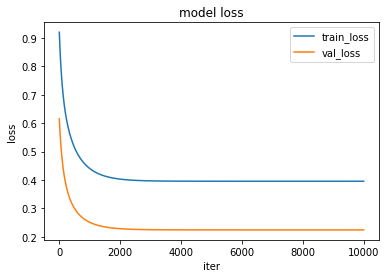

In [10]:
# 可視化
%matplotlib inline
plot_model_loss(clf)

順調に損失関数の値は下がり、2000iteration付近で収束した。

# 【問題7】
## 決定領域の可視化
決定領域を可視化してください。

In [11]:
# validation
x_min, x_max = X_val_std[:, 0].min() - 1, X_val_std[:, 0].max() + 1
y_min, y_max = X_val_std[:, 1].min() - 1, X_val_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

print(xx)
print(yy)

[[-3.12214283 -3.11214283 -3.10214283 ...  3.46785717  3.47785717
   3.48785717]
 [-3.12214283 -3.11214283 -3.10214283 ...  3.46785717  3.47785717
   3.48785717]
 [-3.12214283 -3.11214283 -3.10214283 ...  3.46785717  3.47785717
   3.48785717]
 ...
 [-3.12214283 -3.11214283 -3.10214283 ...  3.46785717  3.47785717
   3.48785717]
 [-3.12214283 -3.11214283 -3.10214283 ...  3.46785717  3.47785717
   3.48785717]
 [-3.12214283 -3.11214283 -3.10214283 ...  3.46785717  3.47785717
   3.48785717]]
[[-3.68165935 -3.68165935 -3.68165935 ... -3.68165935 -3.68165935
  -3.68165935]
 [-3.67165935 -3.67165935 -3.67165935 ... -3.67165935 -3.67165935
  -3.67165935]
 [-3.66165935 -3.66165935 -3.66165935 ... -3.66165935 -3.66165935
  -3.66165935]
 ...
 [ 2.82834065  2.82834065  2.82834065 ...  2.82834065  2.82834065
   2.82834065]
 [ 2.83834065  2.83834065  2.83834065 ...  2.83834065  2.83834065
   2.83834065]
 [ 2.84834065  2.84834065  2.84834065 ...  2.84834065  2.84834065
   2.84834065]]


In [12]:
XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T
print(X_tmp)

Z = clf.predict(X_tmp).reshape(xx.shape)
print(Z)

[[-3.12214283 -3.68165935]
 [-3.11214283 -3.68165935]
 [-3.10214283 -3.68165935]
 ...
 [ 3.46785717  2.84834065]
 [ 3.47785717  2.84834065]
 [ 3.48785717  2.84834065]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


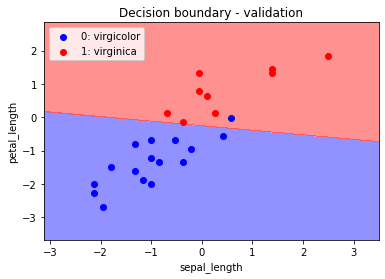

In [13]:
import matplotlib.pyplot as plt

X_val_0 = X_val_std[np.where(y_val==0)]
X_val_1 = X_val_std[np.where(y_val==1)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - validation')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_val_0[:, 0], X_val_0[:, 1], c='blue', label="0: virgicolor")
plt.scatter(X_val_1[:, 0], X_val_1[:, 1], c='red', label="1: virginica")

plt.legend()
plt.show()

In [14]:
# training
x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
y_min, y_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

XX = xx.ravel()
YY = yy.ravel()

X_tmp = np.array([XX, YY]).T

Z = clf.predict(X_tmp).reshape(xx.shape)

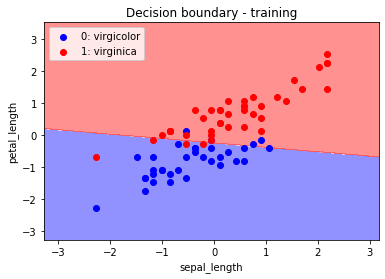

In [15]:
X_train_0 = X_train_std[np.where(y_train==0)]
X_train_1 = X_train_std[np.where(y_train==1)]

%matplotlib inline
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title('Decision boundary - training')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')

plt.contourf(xx, yy, Z, cmap='bwr', alpha=0.5)
plt.scatter(X_train_0[:, 0], X_train_0[:, 1], c='blue', label="0: virgicolor")
plt.scatter(X_train_1[:, 0], X_train_1[:, 1], c='red', label="1: virginica")

plt.legend()
plt.show()

# 【問題8】（アドバンス課題）
## 重みの保存
検証が容易になるように、学習した重みを保存および読み込みができるようにしましょう。pickleモジュールやNumPyのnp.savezを利用します。

[pickle — Python オブジェクトの直列化 — Python 3.7.4 ドキュメント](https://docs.python.org/ja/3/library/pickle.html)

[numpy.savez — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html)

In [16]:
# pickle
import pickle
filename = 'saved_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [17]:
# numpy.savez - Attributesを保存する
np.savez('np_savez', clf.coef_, clf.loss, clf.val_loss)

In [18]:
# 読み込んで比較する
clf1 = pickle.load(open(filename, 'rb'))
clf2 = ScratchLogisticRegression(num_iter=10000, lr=0.01, C=10, no_bias=False, verbose=True)
npz = np.load('np_savez.npz')
clf2.coef_, clf2.loss, clf.val_loss = [npz[x] for x in npz.files]

# パラメータ確認
print(f'clf.coef_  : {clf.coef_.flatten()}')
print(f'clf1.coef_ : {clf1.coef_.flatten()}')
print(f'clf2.coef_ : {clf2.coef_.flatten()}')

# 予測結果確認
y_pred_clf = clf.predict_proba(X_val_std).flatten()
y_pred_clf1 = clf1.predict_proba(X_val_std).flatten()
y_pred_clf2 = clf2.predict_proba(X_val_std).flatten()
print(f'clf_pred  == clf1_pred : {np.allclose(y_pred_clf, y_pred_clf1)}')
print(f'clf1_pred == clf2_pred : {np.allclose(y_pred_clf1, y_pred_clf2)}')
print(f'clf2_pred == clf_pred  : {np.allclose(y_pred_clf2, y_pred_clf)}')

clf.coef_  : [0.2809771  0.1525339  1.11256072]
clf1.coef_ : [0.2809771  0.1525339  1.11256072]
clf2.coef_ : [0.2809771  0.1525339  1.11256072]
clf_pred  == clf1_pred : True
clf1_pred == clf2_pred : True
clf2_pred == clf_pred  : True
